In [9]:
import scanpy as sc
import surgeon

In [10]:
sc.settings.set_figure_params(dpi=200)

In [6]:
condition_key = "study"
cell_type_key = 'cell_type'
target_condition = "Pancreas SS2"

# Loading four pancrease datasets and data preparation

In [2]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type', 'n_counts'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

## visualization  of the original data

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


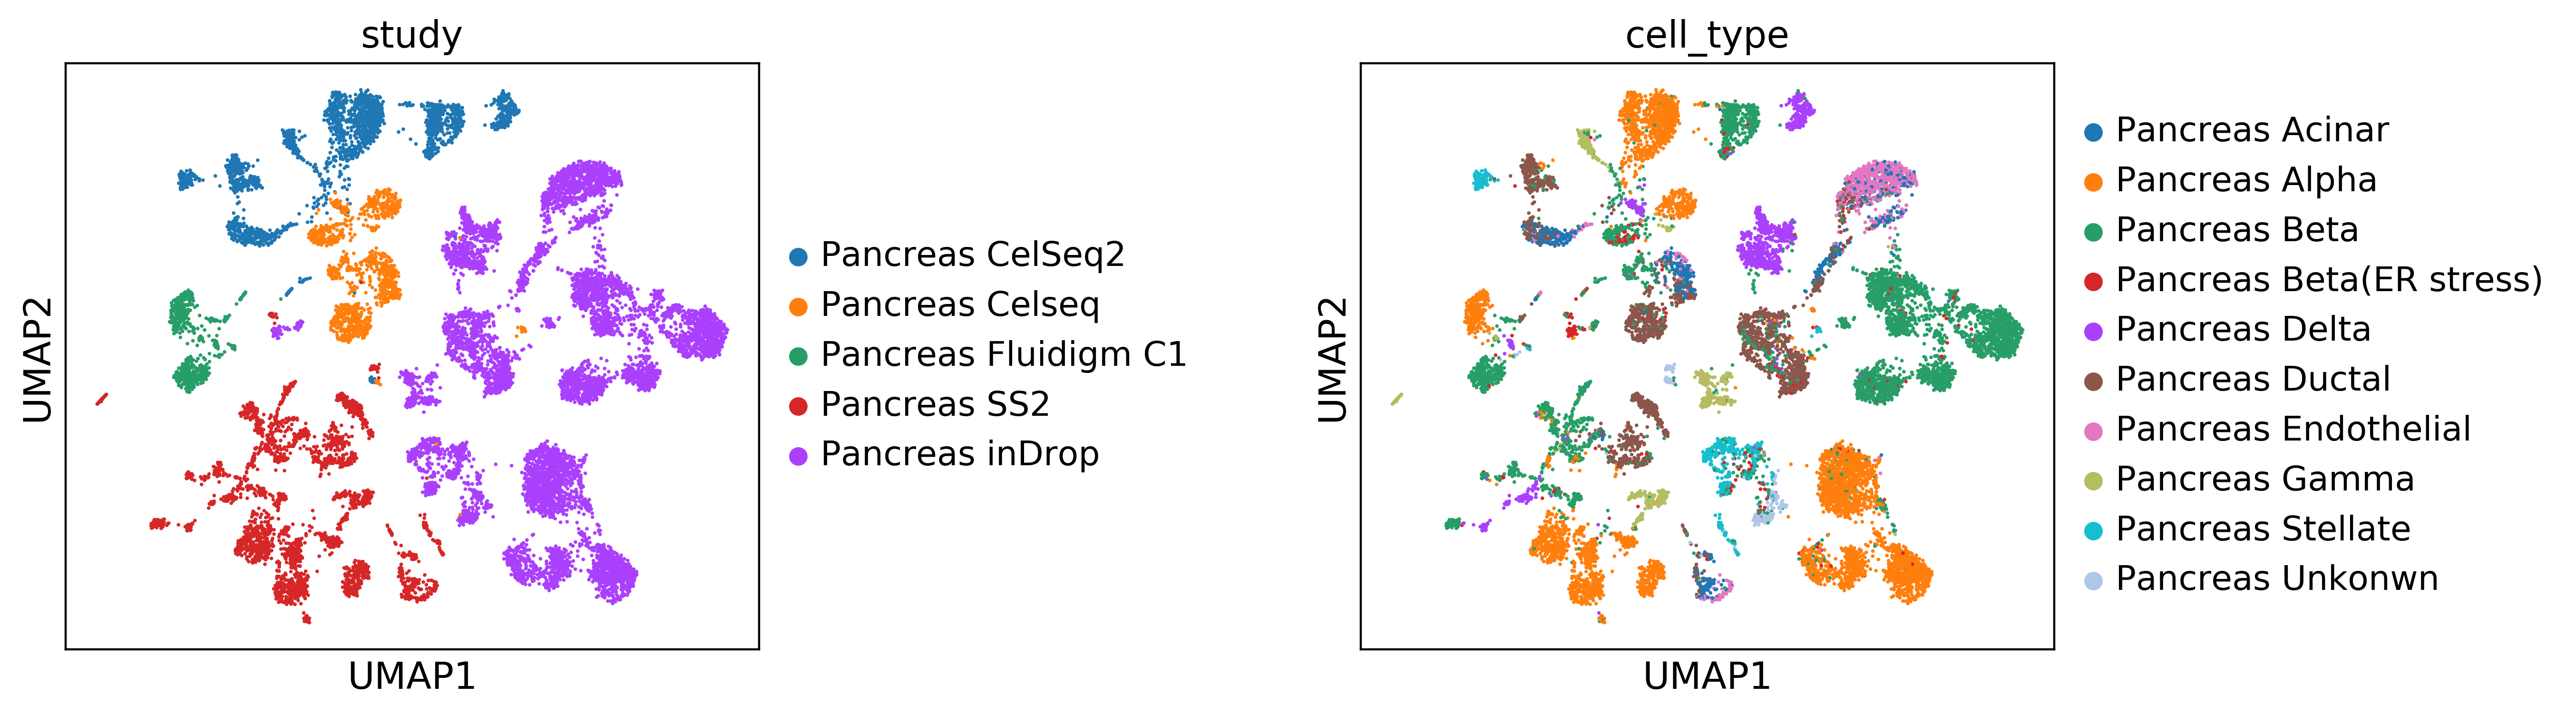

In [12]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.7)

## Now we leave out one study (SS2) for training the newtork

In [13]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 12932 × 15369 
    obs: 'batch', 'study', 'cell_type', 'n_counts'
    uns: 'neighbors', 'study_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

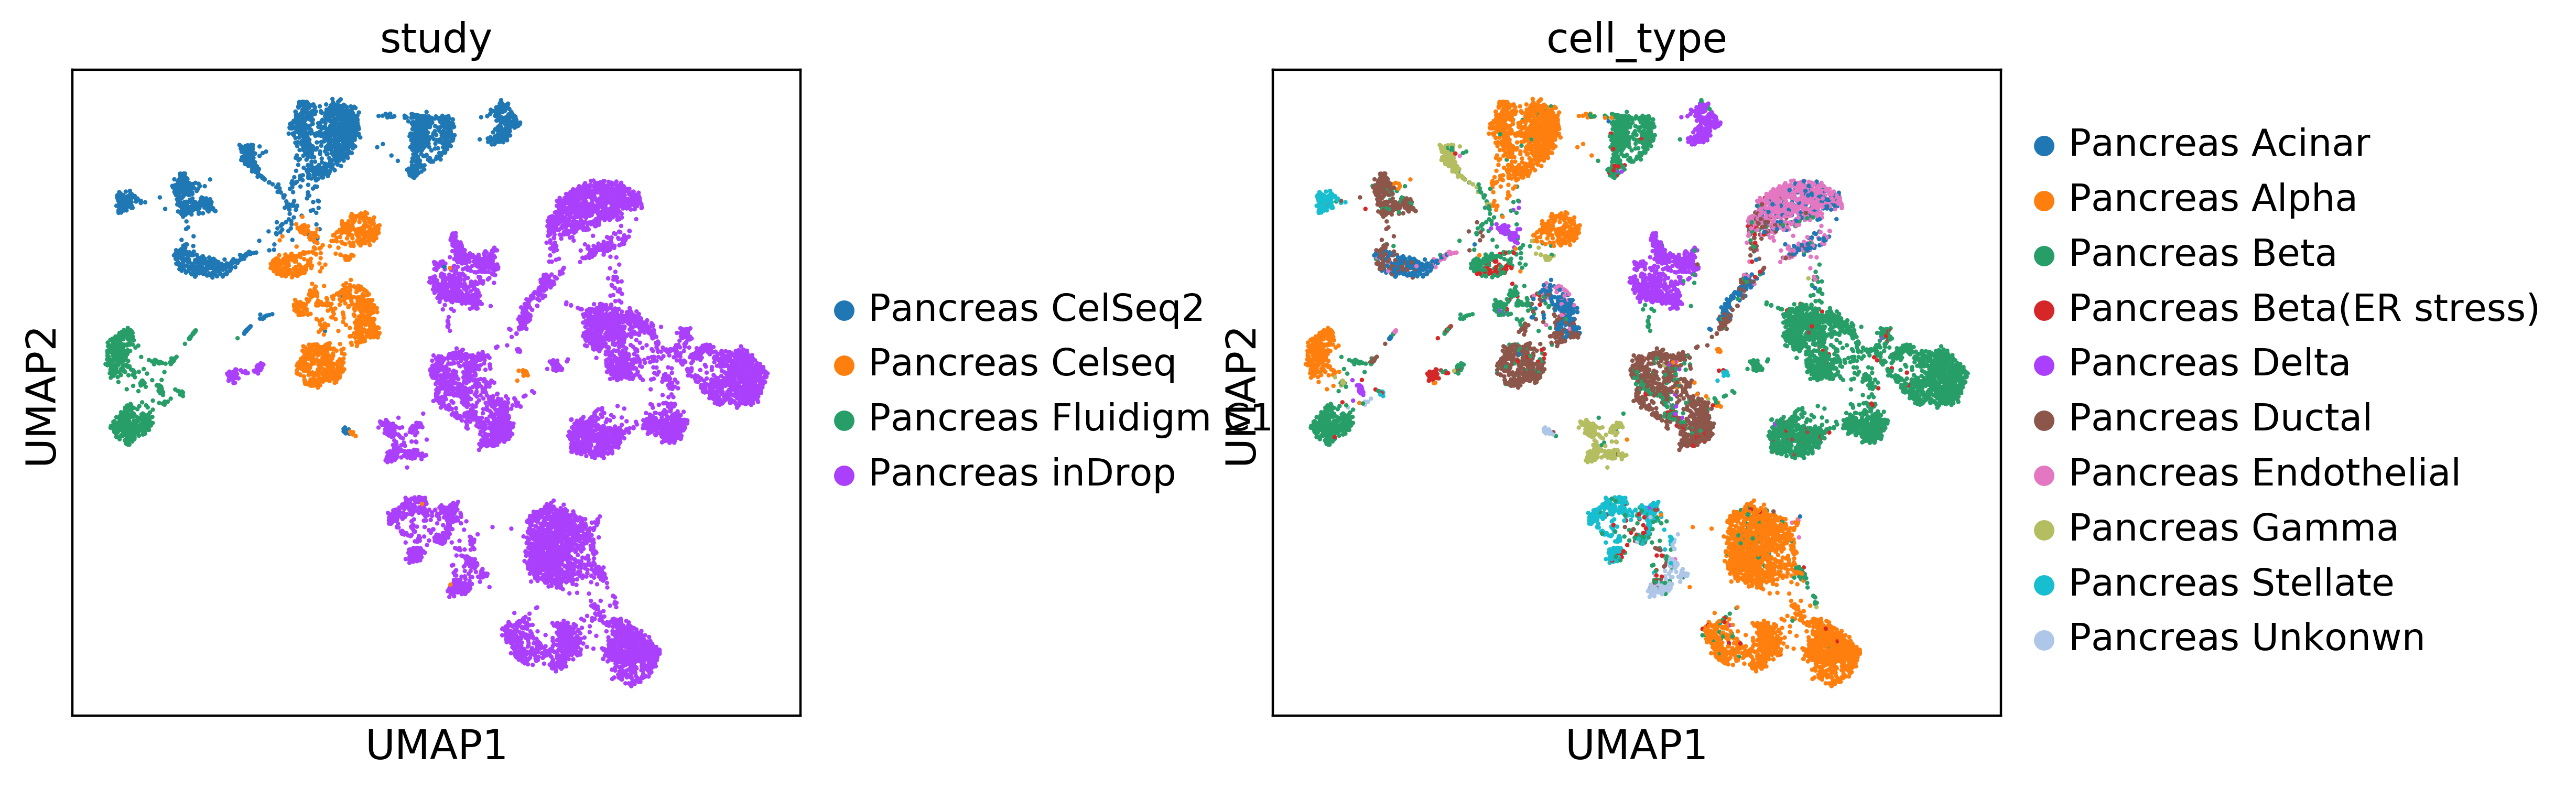

In [14]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [15]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 2989 × 15369 
    obs: 'batch', 'study', 'cell_type', 'n_counts'
    uns: 'neighbors', 'study_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

## Train/Test Split

In [16]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [17]:
train_adata.shape, valid_adata.shape

((10992, 15369), (1940, 15369))

In [18]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [19]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/Pancreas/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 15369)        0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 15373)        0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [20]:
conditions = adata.obs[condition_key].unique().tolist()
target_conditions = [target_condition]
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq2': 1,
 'Pancreas Celseq': 2,
 'Pancreas Fluidigm C1': 3}

## Training the network

In [ ]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=200,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              verbose=2)

In [14]:
network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2}

In [15]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [16]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 9630 × 20 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [17]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

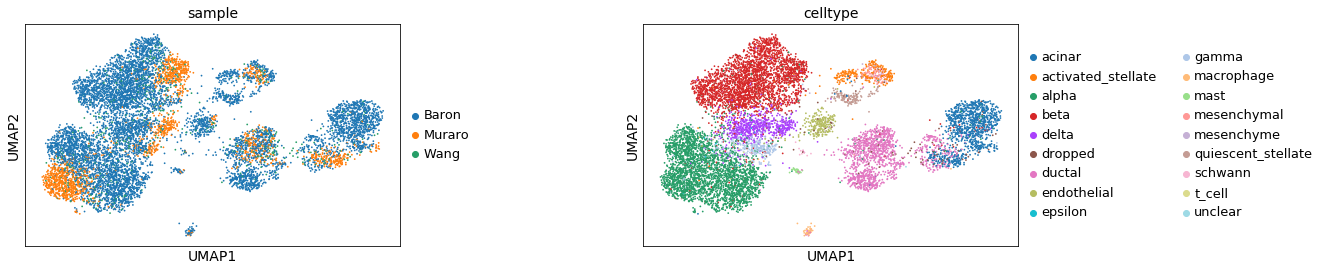

In [18]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [19]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2448)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2452)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1255424     concatenate_3[0][0]              
__________

In [20]:
new_network.condition_encoder

{'Baron': 0, 'Muraro': 1, 'Wang': 2, 'Segerstolpe': 3}

## Train with small new dataset containing out-of-sample condition

In [21]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [22]:
train_adata.shape, valid_adata.shape

((2858, 2448), (505, 2448))

In [23]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 2858 samples, validate on 505 samples
Epoch 1/100
 - 1s - loss: 1078.5296 - kl_recon_loss: 1078.5296 - val_loss: 1062.5228 - val_kl_recon_loss: 1062.5228
Epoch 2/100
 - 0s - loss: 1063.2248 - kl_recon_loss: 1063.2248 - val_loss: 1056.5872 - val_kl_recon_loss: 1056.5872
Epoch 3/100
 - 0s - loss: 1057.5888 - kl_recon_loss: 1057.5888 - val_loss: 1053.5201 - val_kl_recon_loss: 1053.5201
Epoch 4/100
 - 0s - loss: 1053.8980 - kl_recon_loss: 1053.8980 - val_loss: 1051.6894 - val_kl_recon_loss: 1051.6894
Epoch 5/100
 - 0s - loss: 1051.2250 - kl_recon_loss: 1051.2250 - val_loss: 1050.4651 - val_kl_recon_loss: 1050.4651
Epoch 6/100
 - 0s - loss: 1048.9098 - kl_recon_loss: 1048.9098 - val_loss: 1049.4907 - val_kl_recon_loss: 1049.4907
Epoch 7/100
 - 0s - loss: 1047.7076 - kl_recon_loss: 1047.7076 - val_loss: 1048.7288 - val_kl_recon_loss: 1048.7288
Epoch 8/100
 - 0s - loss: 1046.3563 - kl_recon_loss: 1046.3563 - val_loss: 1048.1704 - val_kl_recon_loss: 1048.1704
Epoch 9/100
 - 0s - loss:

In [24]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [25]:
adata.obs[condition_key].value_counts()

Baron          8569
Segerstolpe    3363
Muraro         2126
Wang            635
Name: sample, dtype: int64

In [26]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 14693 × 20 
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'

In [27]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

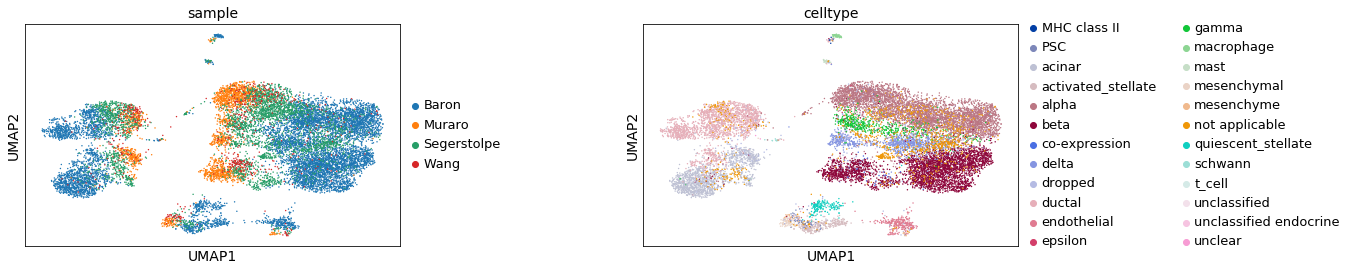

In [28]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)